### Time Series Forecasting using LSTM

In [1]:
# Importing libraries
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
import os

mpl.rcParams['figure.figsize'] = (8,6)
mpl.rcParams['axes.grid'] = False



In [2]:
orig_df = pd.read_csv('/Users/faymajidelhassan/Downloads/Master project /Data/Weather/measurements/lares_weather_measurements.csv') 
df = orig_df.copy() 
print(f'Size of the dataset: {df.shape} \n')  
print() 
display(df.head(5))

Size of the dataset: (2563508, 7) 




,timestamp,temperature,humidity,pressure,global_irradiance,direct_irradiance,diffuse_irradiance
0,2018-04-17 05:24:00,14.1,78.0,9956.0,7.0,0.0,7.0
1,2018-04-17 05:25:00,14.1,78.0,9956.0,8.0,0.0,8.0
2,2018-04-17 05:26:00,14.1,79.0,9956.0,8.0,0.0,8.0
3,2018-04-17 05:27:00,14.1,79.0,9956.0,9.0,0.0,9.0
4,2018-04-17 05:28:00,14.1,79.0,9958.0,10.0,0.0,10.0


In [3]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)
df = df.resample('10T').agg({
    'temperature': 'mean',  # Average temperature for the hour
    'humidity': 'mean',     # Average humidity for the hour
    'pressure': 'mean',     # Average pressure for the hour
    'global_irradiance': 'sum',  # Total irradiance may be summed
    'direct_irradiance': 'sum',
    'diffuse_irradiance': 'sum'
    # 'precipitation': 'sum'
})

Observations:
1) One reading evrry 10 mins (from datatime column time diff for every record )
2) 1day = 6*24 = 144 readings
Task : Forecasting Temperature(in degree ) in future 




In [4]:
## using univariate feature(Only temperature for given time)

uni_data = df['temperature']
# uni_data.index = df['timestamp']
uni_data.head()

timestamp
2018-04-17 05:20:00    14.10
2018-04-17 05:30:00    14.16
2018-04-17 05:40:00    14.32
2018-04-17 05:50:00    14.49
2018-04-17 06:00:00    14.66
Freq: 10T, Name: temperature, dtype: float64

<Axes: xlabel='timestamp'>

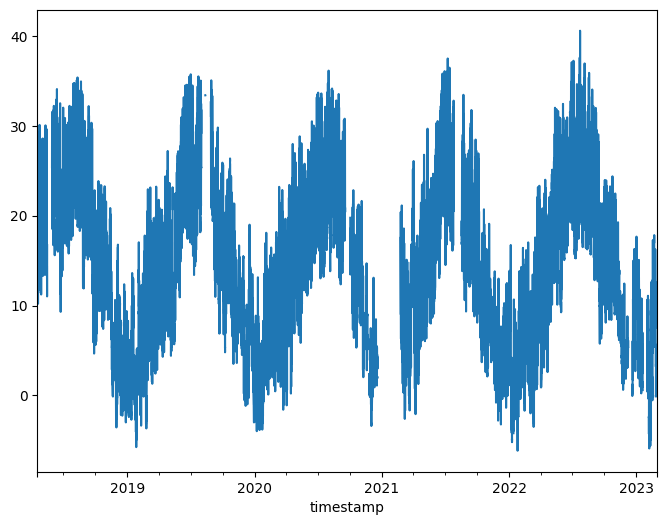

In [5]:
uni_data.plot()

In [6]:
# uni_data = uni_data.values

In [7]:
uni_data.isnull().sum()

34688

In [8]:
uni_data = uni_data.fillna(method='ffill')

In [9]:
uni_data.isnull().sum()

0

In [10]:
uni_data.shape

(256352,)

In [11]:
## train test split for simple time series moving window average
train_split = 205082 #43228
tf.random.set_seed(13)

### standardize data
uni_data_mean = uni_data[:train_split].mean()
uni_data_std = uni_data[:train_split].std()
uni_data  = (uni_data - uni_data_mean)/ uni_data_std

print(type(uni_data))


<class 'pandas.core.series.Series'>


Moving Window Average


1.   Given last 20 values of observations(temp) , predict next observation
2.   MWA: predict== AVG(last 20 values)




In [12]:
## utility functions

## funtion to create data for univariate forecasting

def univariate_data(dataset, start_idx , end_idx , history_size, target_size):
  data = []
  labels = []
  start_idx  = start_idx + history_size
  if end_idx is None:
    end_idx = len(dataset)- target_size
  for i in range(start_idx , end_idx):
    idxs = range(i-history_size , i)
    data.append(np.reshape(dataset[idxs] , (history_size, 1))) ### reshape data
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

uni_data_history = 50   ## last 50 values
uni_data_future = 0     ## future data

x_train_uni , y_train_uni = univariate_data(uni_data , 0 , train_split , uni_data_history , uni_data_future)

x_val_uni , y_val_uni = univariate_data(uni_data , train_split , None ,uni_data_history , uni_data_future)

In [13]:
x_train_uni

array([[[ 0.01922056],
        [ 0.02581526],
        [ 0.04340112],
        ...,
        [ 0.6028513 ],
        [ 0.54349902],
        [ 0.54459814]],

       [[ 0.02581526],
        [ 0.04340112],
        [ 0.0620861 ],
        ...,
        [ 0.54349902],
        [ 0.54459814],
        [ 0.54130079]],

       [[ 0.04340112],
        [ 0.0620861 ],
        [ 0.08077108],
        ...,
        [ 0.54459814],
        [ 0.54130079],
        [ 0.50722819]],

       ...,

       [[-1.51624486],
        [-1.5327316 ],
        [-1.545921  ],
        ...,
        [-1.44150495],
        [-1.39973853],
        [-1.39534207]],

       [[-1.5327316 ],
        [-1.545921  ],
        [-1.55581304],
        ...,
        [-1.39973853],
        [-1.39534207],
        [-1.3975403 ]],

       [[-1.545921  ],
        [-1.55581304],
        [-1.57120067],
        ...,
        [-1.39534207],
        [-1.3975403 ],
        [-1.37226063]]])

In [14]:
print(x_train_uni.shape , y_train_uni.shape)
print(x_val_uni.shape , y_val_uni.shape)

(205032, 50, 1) (205032,)
(51220, 50, 1) (51220,)


In [15]:
print('Single window of history data' , x_train_uni[0])

print('Target Temperature to predict ' , y_train_uni[0])


Single window of history data [[ 0.01922056]
 [ 0.02581526]
 [ 0.04340112]
 [ 0.0620861 ]
 [ 0.08077108]
 [ 0.08846489]
 [ 0.10165428]
 [ 0.08296931]
 [ 0.04010377]
 [-0.02914055]
 [-0.08189813]
 [-0.08079902]
 [-0.05771757]
 [-0.0324379 ]
 [-0.01045557]
 [ 0.00383294]
 [ 0.02361703]
 [ 0.03350908]
 [ 0.0488967 ]
 [ 0.06428433]
 [ 0.11484368]
 [ 0.15770921]
 [ 0.17309684]
 [ 0.19507917]
 [ 0.23684559]
 [ 0.24783675]
 [ 0.27311642]
 [ 0.34016251]
 [ 0.41050596]
 [ 0.46985823]
 [ 0.44677679]
 [ 0.38852363]
 [ 0.39401921]
 [ 0.45337149]
 [ 0.42479447]
 [ 0.51382288]
 [ 0.58306721]
 [ 0.65341065]
 [ 0.63692391]
 [ 0.65450977]
 [ 0.62263539]
 [ 0.61054512]
 [ 0.64571684]
 [ 0.64132037]
 [ 0.61384246]
 [ 0.58526544]
 [ 0.58966191]
 [ 0.6028513 ]
 [ 0.54349902]
 [ 0.54459814]]
Target Temperature to predict  0.5413007907018796


<module 'matplotlib.pyplot' from '/Users/faymajidelhassan/anaconda3/envs/m/lib/python3.10/site-packages/matplotlib/pyplot.py'>

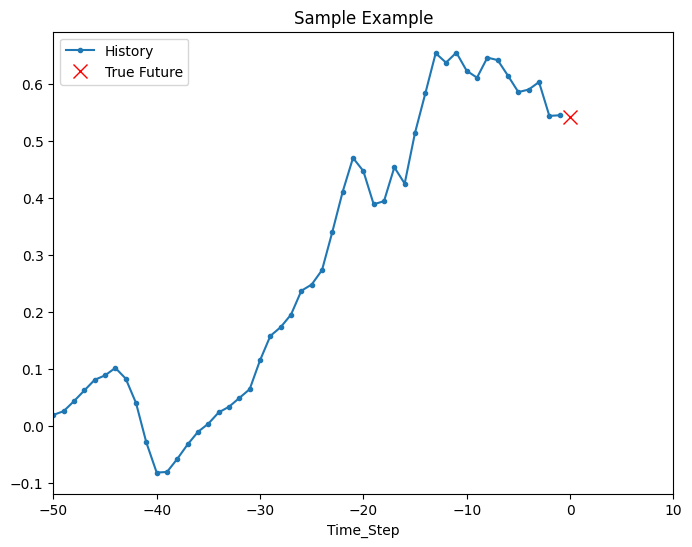

In [16]:
### fucntion to create time steps
def create_time_steps(length):
  return list(range(-length,0))

### function to plot time series data

def plot_time_series(plot_data, delta , title):
  labels = ["History" , 'True Future' , 'Model Predcited']
  marker = ['.-' , 'rx' , 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])

  if delta:
    future = delta
  else:
    future = 0
  plt.title(title)
  for i , x in enumerate(plot_data):
    if i :
      plt.plot(future , plot_data[i] , marker[i], markersize = 10 , label = labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label = labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5) *2])

  plt.xlabel('Time_Step')
  return plt

plot_time_series([x_train_uni[0] , y_train_uni[0]] , 0 , 'Sample Example')

<module 'matplotlib.pyplot' from '/Users/faymajidelhassan/anaconda3/envs/m/lib/python3.10/site-packages/matplotlib/pyplot.py'>

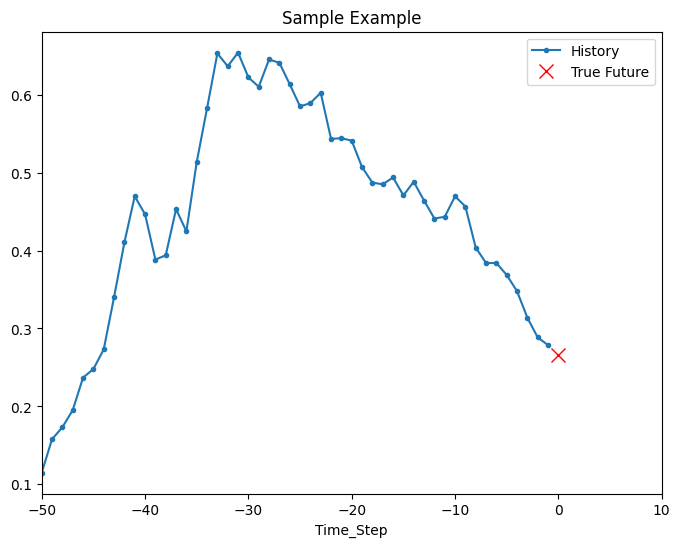

In [17]:
i = 20
plot_time_series([x_train_uni[i], y_train_uni[i]] , 0 , 'Sample Example')

In [18]:
### Moving window average

def MWA(history):
  return np.mean(history)




<module 'matplotlib.pyplot' from '/Users/faymajidelhassan/anaconda3/envs/m/lib/python3.10/site-packages/matplotlib/pyplot.py'>

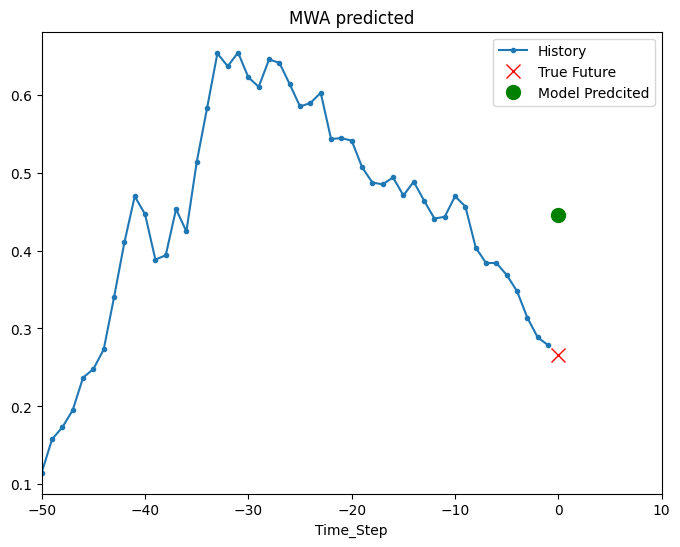

In [19]:
i = 20
plot_time_series([x_train_uni[i] , y_train_uni[i] , MWA(x_train_uni[i])] , 0 , 'MWA predicted')

Univariate time-series forecasting


*   Only single feature as temperature(historical data)
*   Task:  Given last 20 observations(history) , predict next temperature value 



In [20]:
## prepare tensorflow dataset
batch_size = 256
buffer_size = 100000

train_uni = tf.data.Dataset.from_tensor_slices((x_train_uni , y_train_uni))
train_uni = train_uni.cache().shuffle(buffer_size).batch(batch_size).repeat()

val_uni = tf.data.Dataset.from_tensor_slices((x_val_uni , y_val_uni))
val_uni = val_uni.cache().shuffle(buffer_size).batch(batch_size).repeat()

print(train_uni)
print(val_uni)

<_RepeatDataset element_spec=(TensorSpec(shape=(None, 50, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>
<_RepeatDataset element_spec=(TensorSpec(shape=(None, 50, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>


In [61]:
## Define LSTM model 

lstm_model = tf.keras.models.Sequential([tf.keras.layers.LSTM(16 , input_shape = x_train_uni.shape[-2:]), 
                                         tf.keras.layers.Dense(1)])

lstm_model.compile(optimizer = 'adam', loss = 'mae')

steps = 144

EPOCHS =30

lstm_model.fit(train_uni , epochs = EPOCHS, steps_per_epoch = steps ,
               validation_data = val_uni, validation_steps = 50)




Epoch 1/30


144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.3462 - val_loss: 0.0553
Epoch 2/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0458 - val_loss: 0.0376
Epoch 3/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0345 - val_loss: 0.0330
Epoch 4/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0310 - val_loss: 0.0292
Epoch 5/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0275 - val_loss: 0.0265
Epoch 6/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0253 - val_loss: 0.0257
Epoch 7/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0252 - val_loss: 0.0237
Epoch 8/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0215 - val_loss: 0.0230
Epoch 9/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0211 - val_loss: 0.0216
Epoch 10/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0210 - val_loss: 0.0215
Epoch 11/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0196 - val_loss: 0.0211
Epoch 12/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/ste

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  


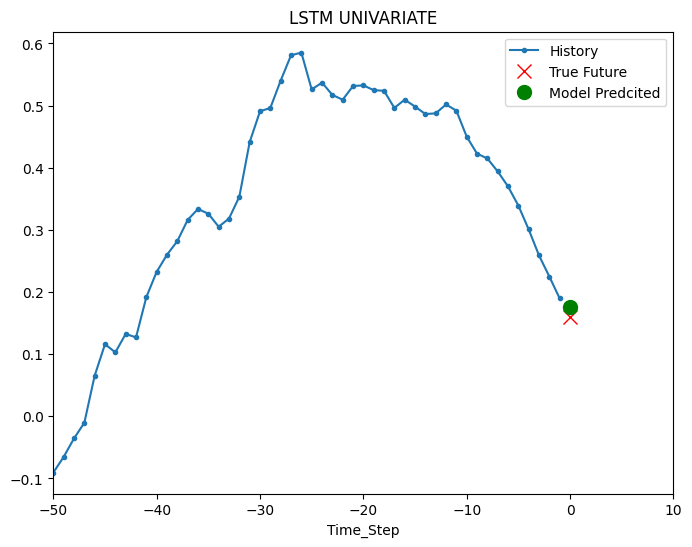

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


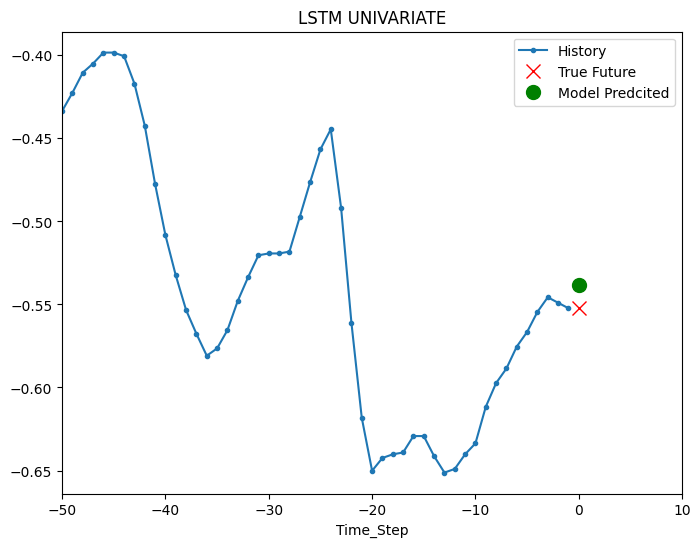

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


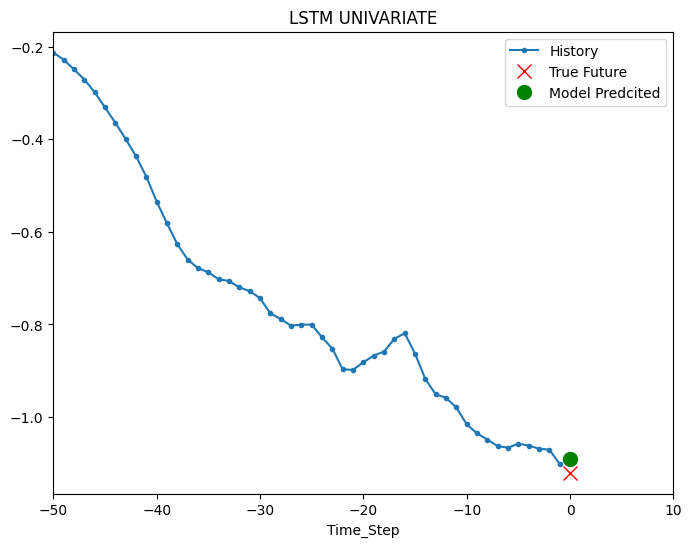

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


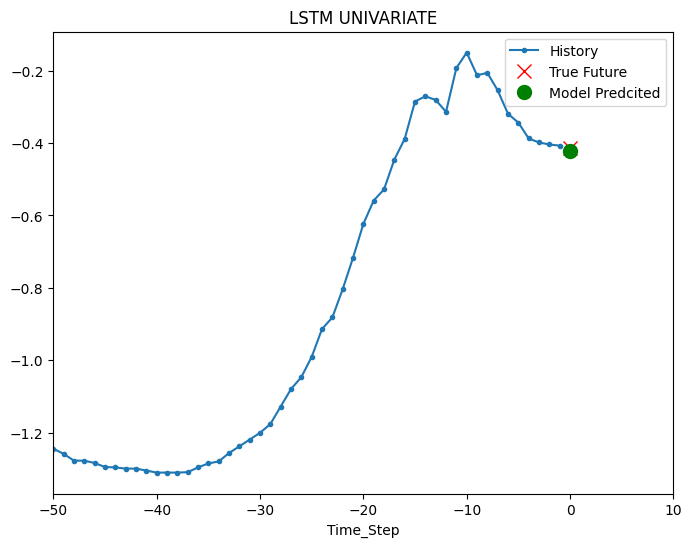

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


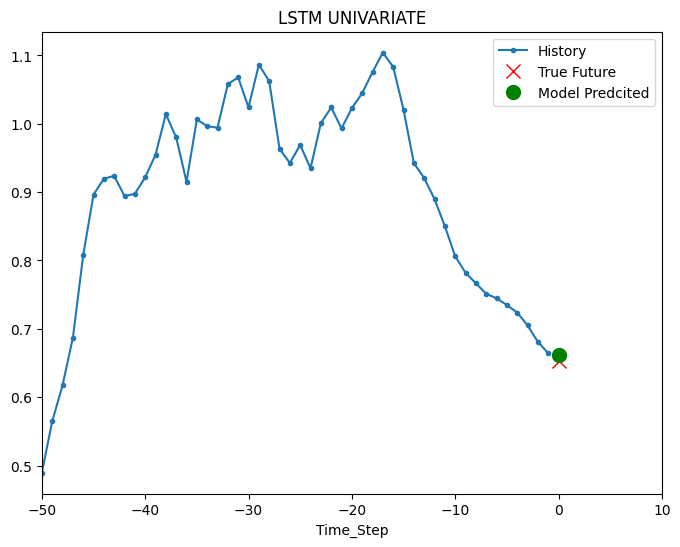

2024-05-19 23:18:05.793509: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [43]:
for i , j in val_uni.take(5):
  plot = plot_time_series([i[0].numpy() , j[0].numpy() , lstm_model.predict(i)[0]] ,0 , 'LSTM UNIVARIATE')
  plot.show()

Multivariate  and Single step Forecasting


*   Task: Given 3 features(temp , pressure , and density) at each time step can we predict the temp in future at single time step




In [44]:
## features 

features_6 = ['temperature', 'humidity', 'pressure', 'global_irradiance', 'direct_irradiance', 'diffuse_irradiance']

features = df[features_6]
features.head()



,temperature,humidity,pressure,global_irradiance,direct_irradiance,diffuse_irradiance
timestamp,,,,,,
2018-04-17 05:20:00,14.10,78.666667,9956.666667,54.0,0.0,54.0
2018-04-17 05:30:00,14.16,78.100000,9958.400000,178.0,0.0,178.0
2018-04-17 05:40:00,14.32,78.000000,9959.800000,322.0,0.0,321.0
2018-04-17 05:50:00,14.49,78.600000,9960.900000,560.0,0.0,560.0
2018-04-17 06:00:00,14.66,78.100000,9963.000000,643.0,0.0,645.0


In [45]:
features=features.fillna(method='ffill')

In [46]:
# features.fillna(method='bfill')

In [47]:
features.isnull().sum()

temperature           0
humidity              0
pressure              0
global_irradiance     0
direct_irradiance     0
diffuse_irradiance    0
dtype: int64

array([<Axes: xlabel='timestamp'>, <Axes: xlabel='timestamp'>,
       <Axes: xlabel='timestamp'>, <Axes: xlabel='timestamp'>,
       <Axes: xlabel='timestamp'>, <Axes: xlabel='timestamp'>],
      dtype=object)

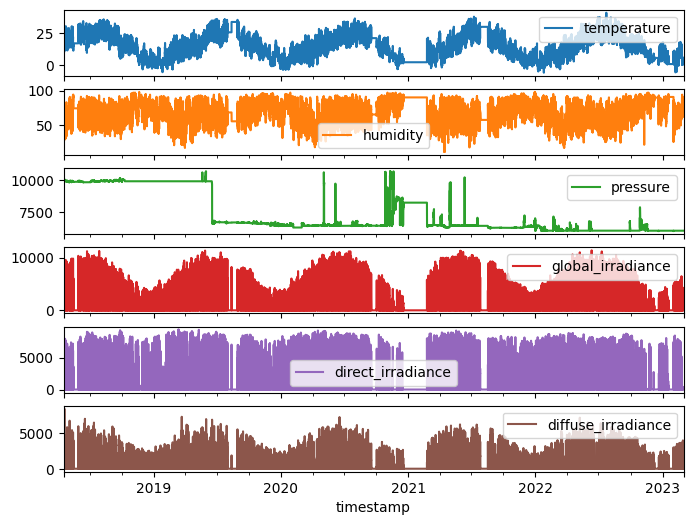

In [48]:
features.plot(subplots=True)

In [49]:
### standardize data
dataset = features.values

data_mean = dataset[:train_split].mean(axis =0)

data_std = dataset[:train_split].std(axis = 0)

dataset = (dataset - data_mean)/data_std



In [50]:
### create mutlivariate data

def mutlivariate_data(dataset , target , start_idx , end_idx , history_size , target_size,
                      step ,  single_step = False):
  data = []
  labels = []
  start_idx = start_idx + history_size
  if end_idx is None:
    end_idx = len(dataset)- target_size
  for i in range(start_idx , end_idx ):
    idxs = range(i-history_size, i, step) ### using step
    data.append(dataset[idxs])
    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data) , np.array(labels)



In [51]:
# ### generate multivariate data

history = 720
future_target = 72
STEP = 6

x_train_ss , y_train_ss = mutlivariate_data(dataset , dataset[:, 1], 0, train_split, history,
                                            future_target, STEP , single_step = True)

x_val_ss , y_val_ss = mutlivariate_data(dataset , dataset[:,1] , train_split , None , history ,
                                        future_target, STEP, single_step = True)

print(x_train_ss.shape , y_train_ss.shape)

### generate multivariate data

# history = 720
# future_target = 72
# STEP = 6

# # Use multiple features from the dataset
# x_train_ss, y_train_ss = mutlivariate_data(dataset.values, dataset.values[:, 0], 0, train_split, history,
#                                            future_target, STEP, single_step=True)

# x_val_ss, y_val_ss = mutlivariate_data(dataset.values, dataset.values[:, 0], train_split, None, history,
#                                        future_target, STEP, single_step=True)

# print(x_train_ss.shape, y_train_ss.shape)
print(x_val_ss.shape, y_val_ss.shape)


(204074, 168, 6) (204074,)
(50190, 168, 6) (50190,)


In [52]:
## tensorflow dataset

train_ss = tf.data.Dataset.from_tensor_slices((x_train_ss, y_train_ss))
train_ss = train_ss.cache().shuffle(buffer_size).batch(batch_size).repeat()

val_ss = tf.data.Dataset.from_tensor_slices((x_val_ss, y_val_ss))
val_ss = val_ss.cache().shuffle(buffer_size).batch(batch_size).repeat()

print(train_ss)
print(val_ss)



<_RepeatDataset element_spec=(TensorSpec(shape=(None, 168, 6), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>
<_RepeatDataset element_spec=(TensorSpec(shape=(None, 168, 6), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>


In [62]:
### Modelling using LSTM

single_step_model = tf.keras.models.Sequential()

single_step_model.add(tf.keras.layers.LSTM(16, input_shape = x_train_ss.shape[-2:]))
# single_step_model.add(tf.keras.layers.LSTM(32,return_sequences=True))
# single_step_model.add(tf.keras.layers.Dense(32, activation="relu"))
single_step_model.add(tf.keras.layers.Dense(1))
single_step_model.compile(optimizer = tf.keras.optimizers.Adam(weight_decay=1e-6), loss = 'mae')
single_step_model_history = single_step_model.fit(train_ss, epochs = EPOCHS , 
                                                  steps_per_epoch =steps, validation_data = val_ss,
                                                  validation_steps = 50)


Epoch 1/30


144/144 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - loss: 0.6789 - val_loss: 0.5257
Epoch 2/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - loss: 0.4674 - val_loss: 0.4825
Epoch 3/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - loss: 0.4344 - val_loss: 0.4734
Epoch 4/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - loss: 0.4258 - val_loss: 0.4673
Epoch 5/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - loss: 0.4164 - val_loss: 0.4557
Epoch 6/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - loss: 0.4137 - val_loss: 0.4793
Epoch 7/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - loss: 0.4345 - val_loss: 0.4772
Epoch 8/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - loss: 0.4048 - val_loss: 0.4542
Epoch 9/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - loss: 0.3936 - val_loss: 0.4696
Epoch 10/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - loss: 0.4090 - val_loss: 0.4582
Epoch 11/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - loss: 0.4052 - val_loss: 0.4462
Epoch 12/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/ste

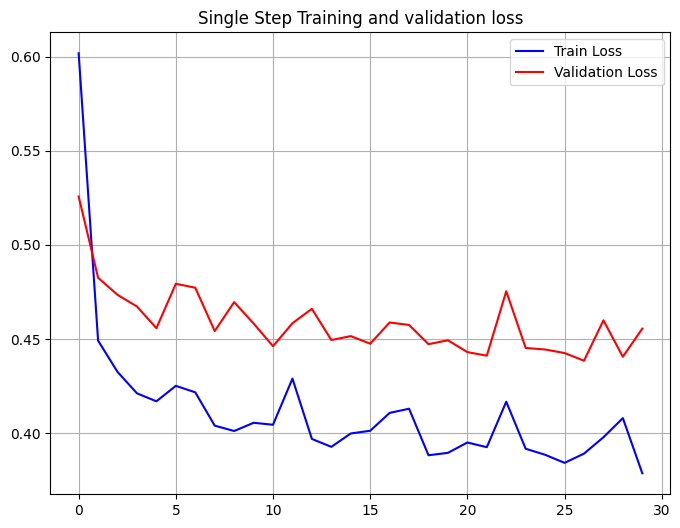

In [63]:
## plot train test loss 

def plot_loss(history , title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))
  plt.figure()
  plt.plot(epochs, loss , 'b' , label = 'Train Loss')
  plt.plot(epochs, val_loss , 'r' , label = 'Validation Loss')
  plt.title(title)
  plt.legend()
  plt.grid()
  plt.show()

plot_loss(single_step_model_history , 'Single Step Training and validation loss')

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step  


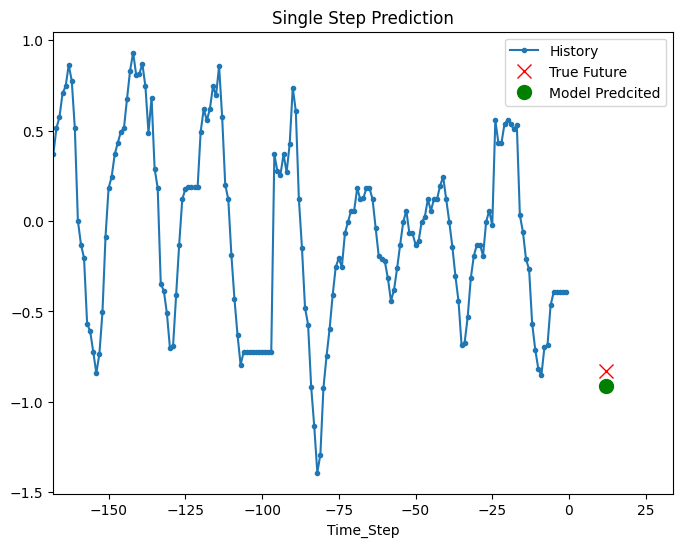

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


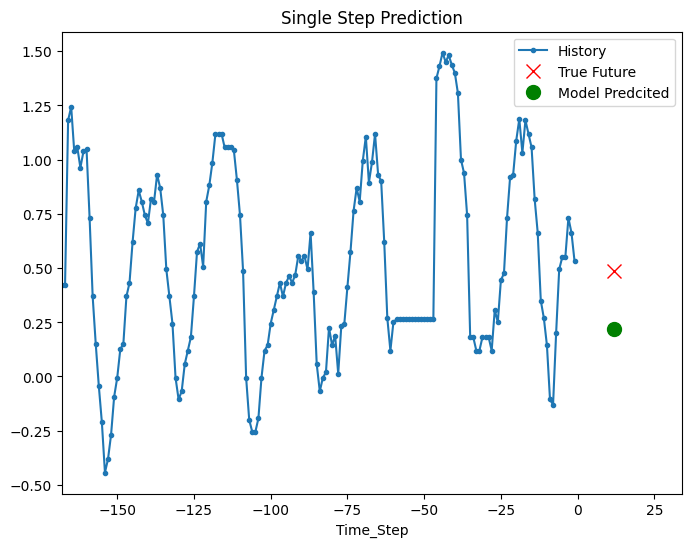

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


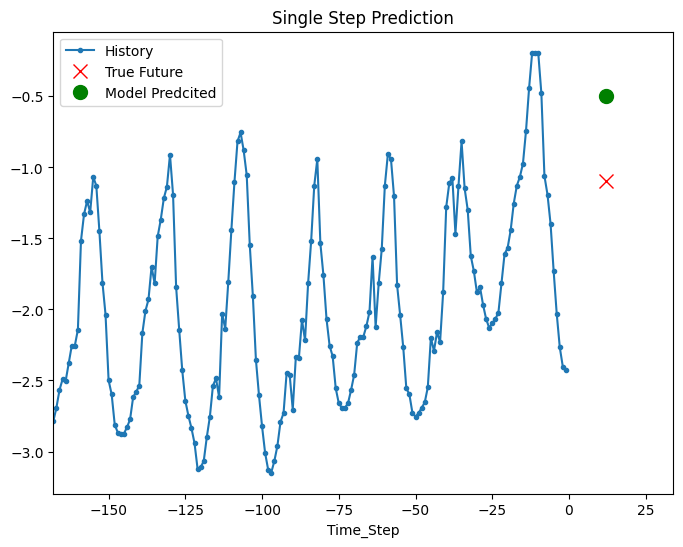

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


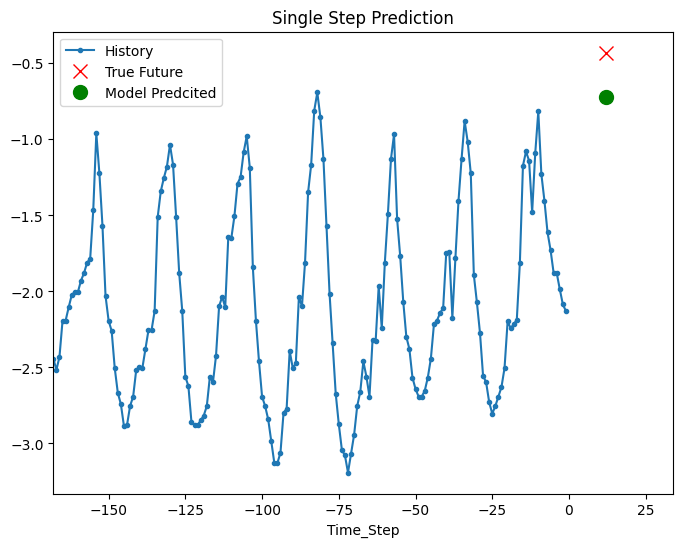

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


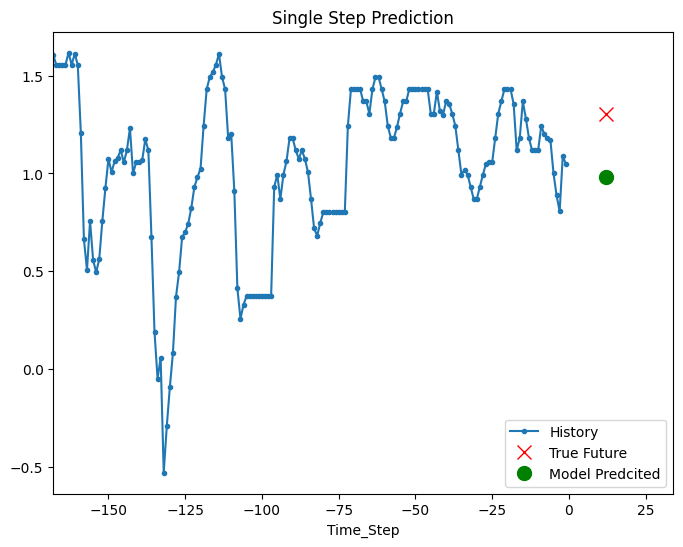

2024-05-19 23:33:28.325262: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [64]:
# plot time series and predicted values

for x, y in val_ss.take(5):
  plot = plot_time_series([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 12,
                   'Single Step Prediction')
  plot.show()

Multi-variate & multi-step forecasting
-> Generate multiple future values of temperature

In [65]:
future_target = 72 # 72 future values
x_train_multi, y_train_multi = mutlivariate_data(dataset, dataset[:, 1], 0,
                                                 train_split, history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = mutlivariate_data(dataset, dataset[:, 1],
                                             train_split, None, history,
                                             future_target, STEP)

print(x_train_multi.shape)
print(y_train_multi.shape)

### generate multivariate data

# history = 720
# future_target = 72
# STEP = 6

# # Use multiple features from the dataset
# x_train_multi, y_train_multi = mutlivariate_data(dataset.values, dataset.values[:, 0], 0, train_split, history,
#                                            future_target, STEP, single_step=True)

# x_val_multi, y_val_ = mutlivariate_data(dataset.values, dataset.values[:, 0], train_split, None, history,
#                                        future_target, STEP, single_step=True)

# print(x_train_ss.shape, y_train_ss.shape)
# print(x_val_ss.shape, y_val_ss.shape)


(204074, 168, 6)
(204074, 72)


In [66]:
# TF DATASET

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(buffer_size).batch(batch_size).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(batch_size).repeat()

2024-05-19 23:33:52.017080: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


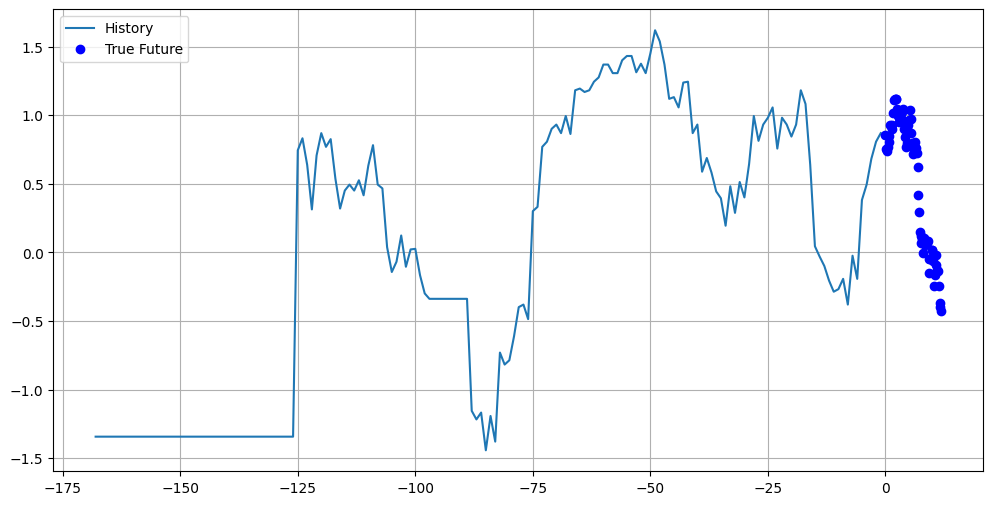

2024-05-19 23:33:52.139193: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [67]:
#plotting function
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)
  plt.grid()
  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()
  


for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))

In [69]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(16,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(8, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(72)) # for 72 outputs

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=steps,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Epoch 1/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 13s 74ms/step - loss: 1.7438 - val_loss: 0.8309
Epoch 2/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 11s 74ms/step - loss: 1.5789 - val_loss: 0.6602
Epoch 3/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 11s 75ms/step - loss: 0.5387 - val_loss: 0.4366
Epoch 4/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 11s 76ms/step - loss: 0.4866 - val_loss: 0.3685
Epoch 5/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 11s 74ms/step - loss: 0.4276 - val_loss: 0.4628
Epoch 6/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 11s 75ms/step - loss: 0.3891 - val_loss: 0.4510
Epoch 7/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - loss: 0.3914 - val_loss: 0.3136
Epoch 8/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 11s 75ms/step - loss: 0.3491 - val_loss: 0.3110
Epoch 9/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - loss: 0.3431 - val_loss: 0.3846
Epoch 10/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 11s 76ms/step - loss: 0.3388 - val_loss: 0.3933
Epoch 11/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - loss: 0.3328 - val_loss: 0.2528
Epoch 12/30
144/144 ━━━━━━━━━━

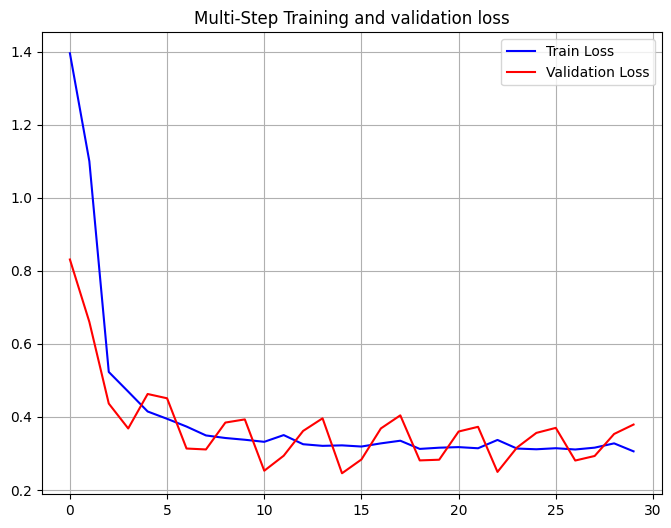

In [70]:
plot_loss(multi_step_history, 'Multi-Step Training and validation loss')


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


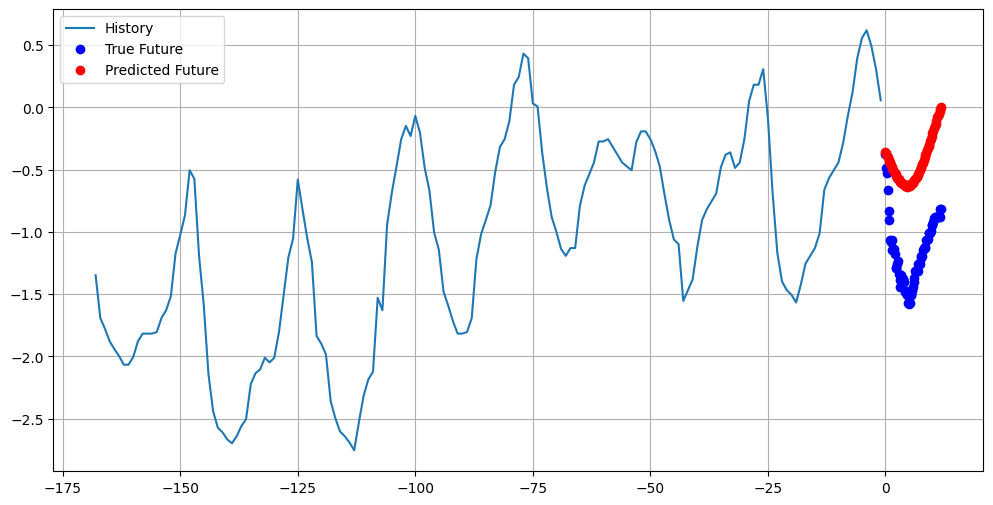

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


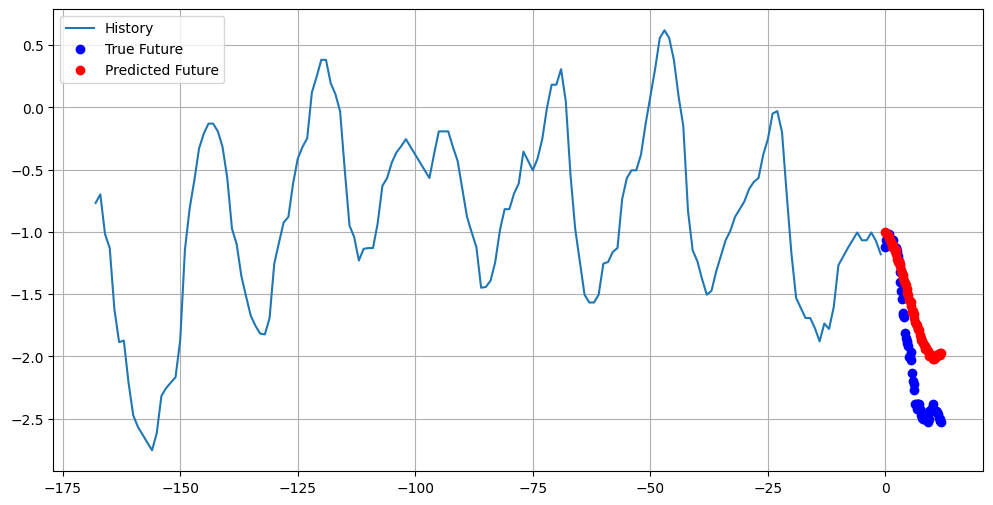

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


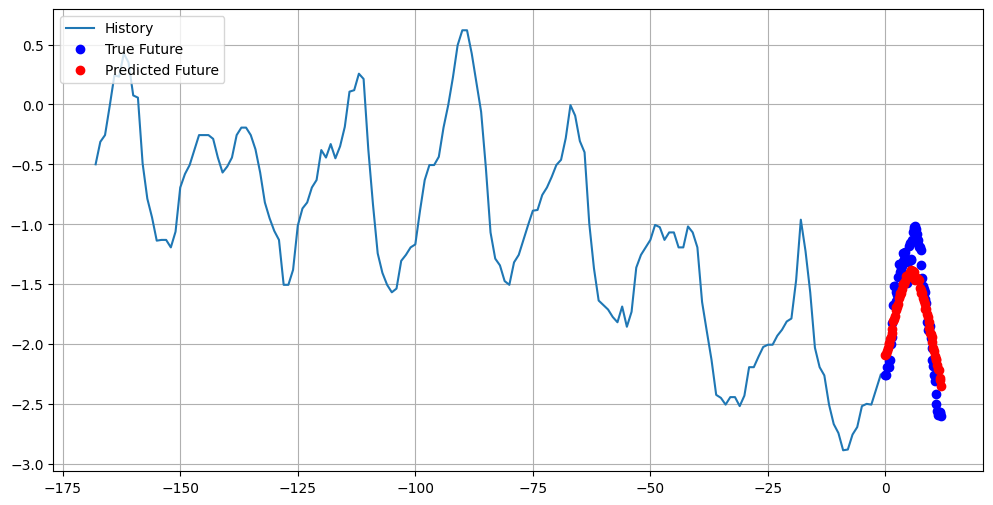

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


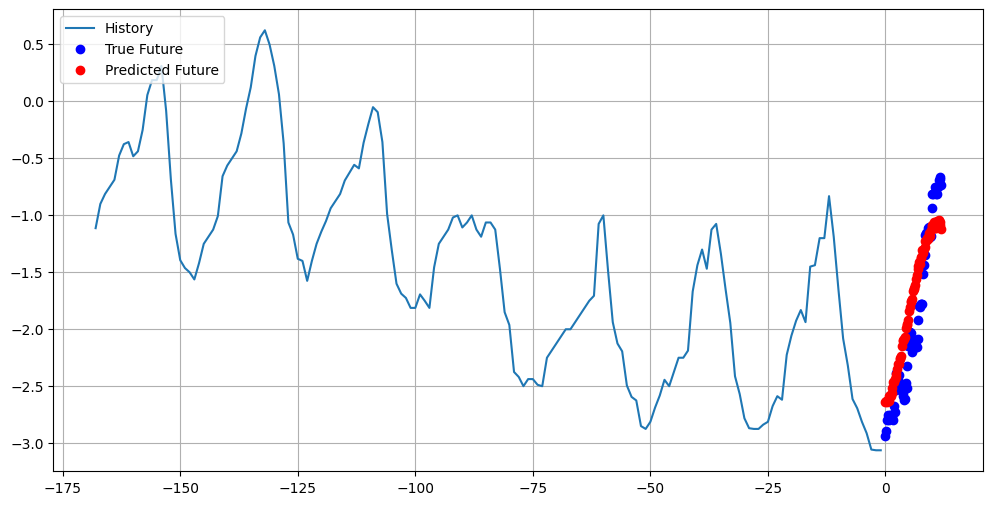

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


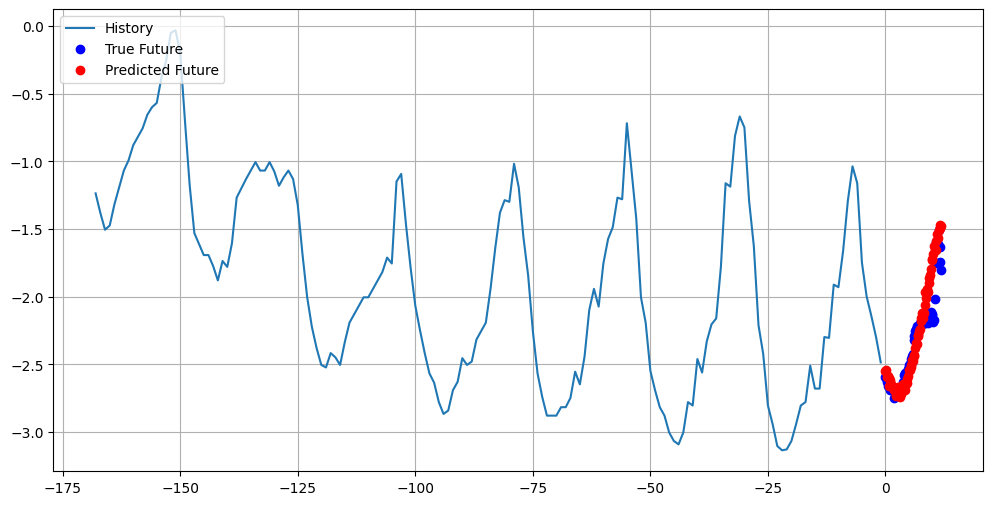

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


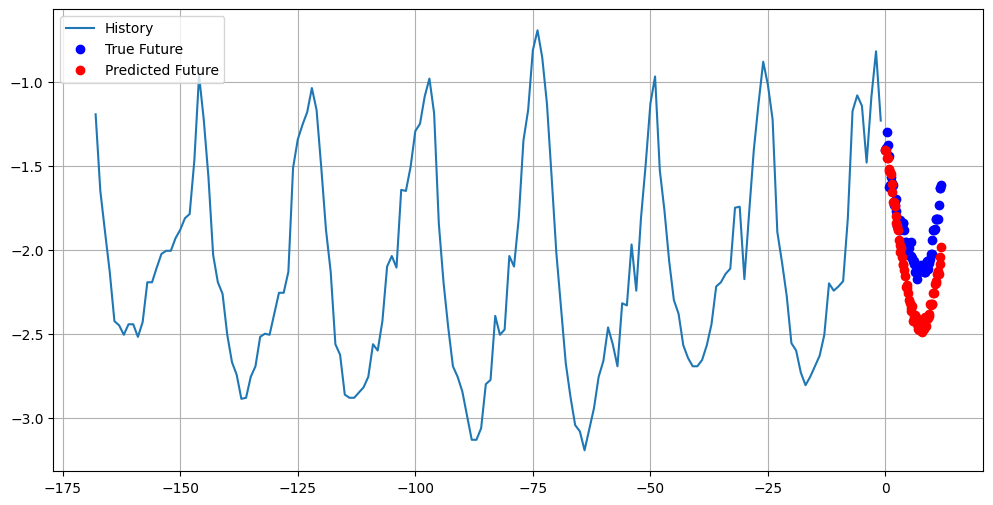

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


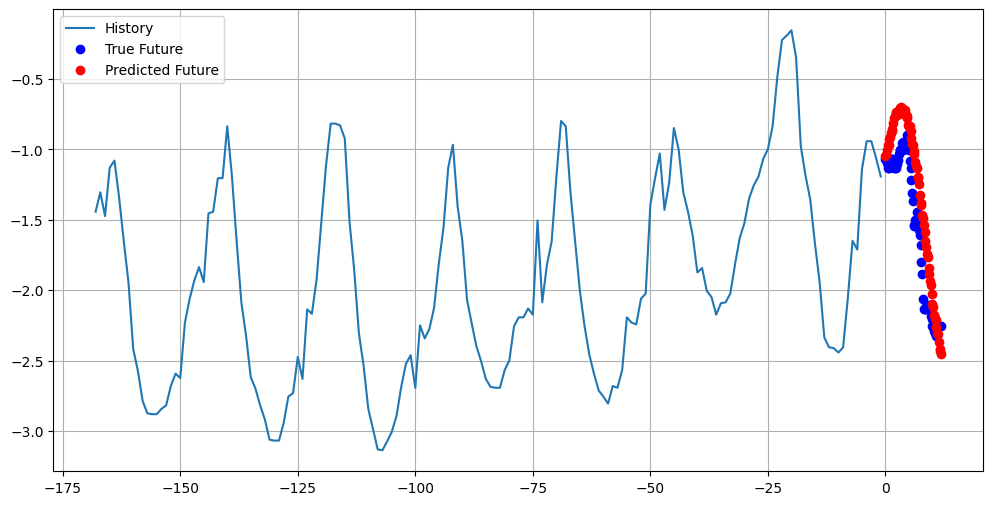

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


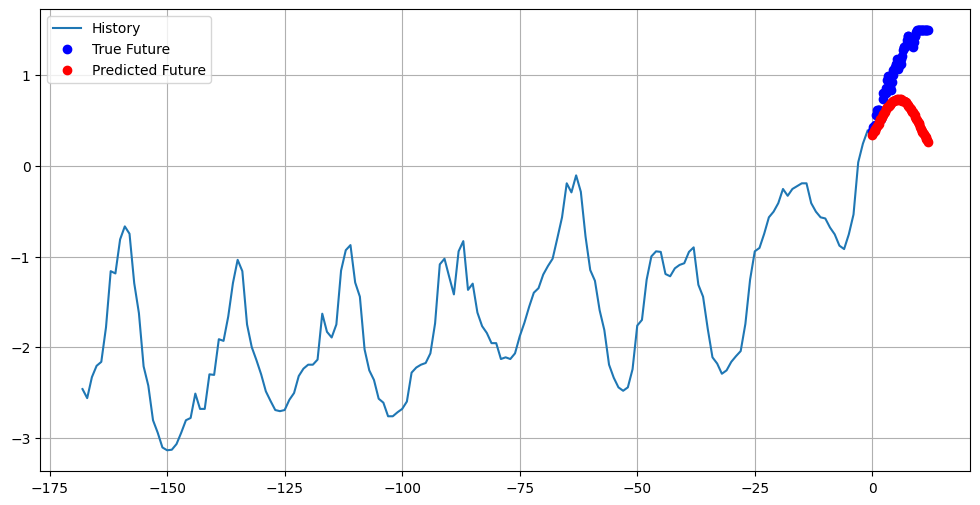

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


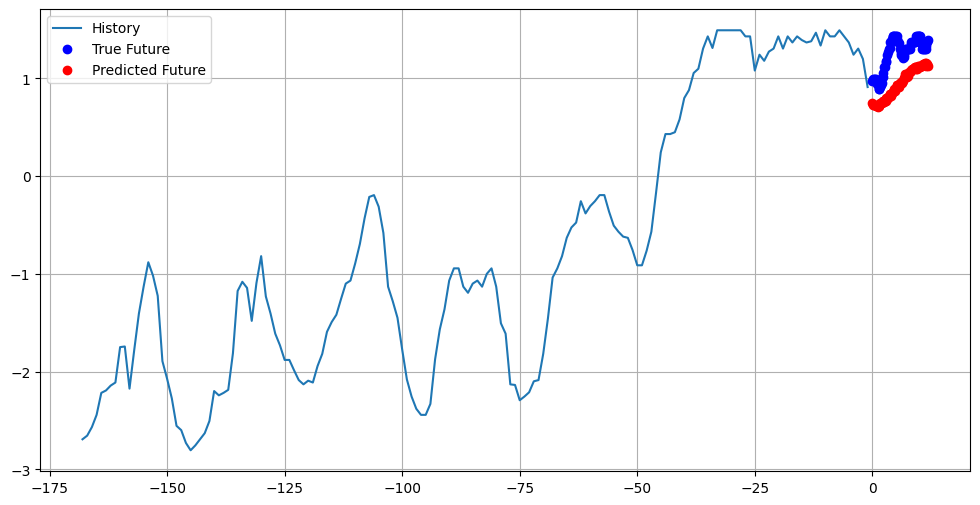

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


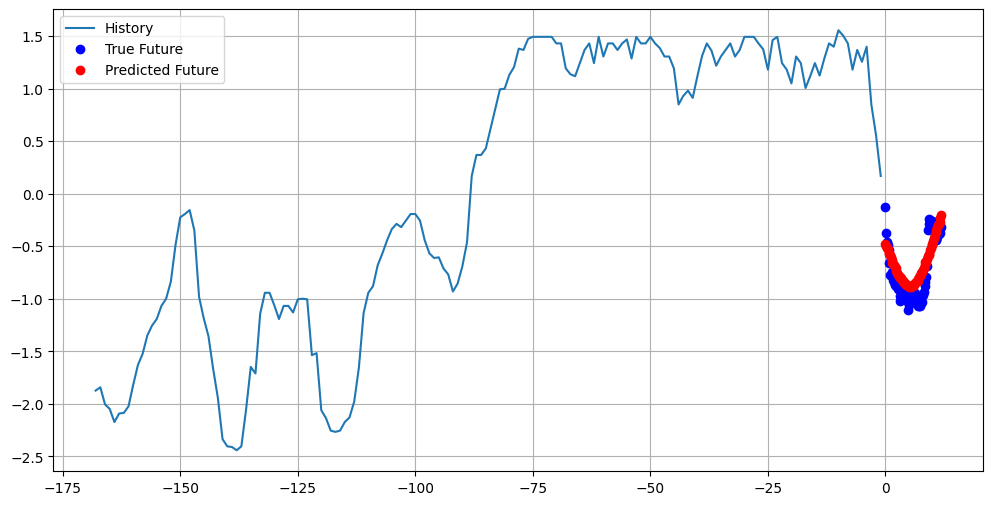

2024-05-19 23:41:58.405252: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [72]:
for x, y in val_data_multi.take(10):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])

In [ ]:
# from statsmodels.tsa.statespace.sarimax import SARIMAX

# # # Assuming you want to use temperature data from x_train
# # endog = x_train_ss[:, :, 0].reshape(-1)  # Selecting the first column (temperature) as endogenous variable and reshaping to 1D

# # # Define SARIMAX model
# # model = SARIMAX(endog, order=(0, 1, 3), seasonal_order=(0, 1, 1, 12))

# # # Fit the model
# # results = model.fit(method='powell')  # Try using the 'powell' method

# # # Print summary
# # print(results.summary())
# # Train SARIMAX model
# endog = df['temperature'][:train_split]  # Using temperature data up to train split for endogenous variable

# sarimax_model = SARIMAX(endog, order=(1, 1, 1), seasonal_order=(1, 1, 1, 144))  # Adjust seasonal_order as per your data frequency
# sarimax_result = sarimax_model.fit(disp=False)

# # Forecast using SARIMAX
# sarimax_forecast = sarimax_result.forecast(steps=len(df) - train_split)


In [73]:
import xgboost as xgb

# Define and train XGBoost model
# model_xgb = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
# model_xgb.fit(x_train_ss.reshape(x_train_ss.shape[0], -1), y_train_ss)
# Train XGBoost model
model_xgb = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
model_xgb.fit(x_train_multi.reshape(x_train_multi.shape[0], -1), y_train_multi[:, -1])  # Using the last value of the future target for training


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [75]:
# Evaluate LSTM model
mae_lstm_single = single_step_model.evaluate(val_ss, steps=100)
mae_lstm_multi=multi_step_model.evaluate(val_data_multi, steps=100)
# # Predict using SARIMAX model
# # sarimax_forecast = results.forecast(steps=len(y_val_ss))

# # Calculate MAE for SARIMAX model
# # mae_sarimax = np.mean(np.abs(sarimax_forecast - y_val_ss))

# # Predict using XGBoost model
# xgb_forecast = model_xgb.predict(x_val_ss.reshape(x_val_ss.shape[0], -1))

# # Calculate MAE for XGBoost model
# mae_xgb = np.mean(np.abs(xgb_forecast - y_val_ss))

# print("MAE for LSTM:", mae_lstm)
# # print("MAE for SARIMAX:", mae_sarimax)
# print("MAE for XGBoost:", mae_xgb)

# # Evaluate LSTM model
# mae_lstm = lstm_uni_model.evaluate(val_uni, steps=50)

# Evaluate XGBoost model
xgb_forecast = model_xgb.predict(x_val_multi.reshape(x_val_multi.shape[0], -1))
mae_xgb = np.mean(np.abs(xgb_forecast - y_val_multi[:, -1]))

# Calculate MAE for SARIMAX model
# mae_sarimax = np.mean(np.abs(sarimax_forecast - df['temperature'][train_split:]))

print(f"MAE for single LSTM: {mae_lstm_single}")
print(f"MAE for LSTM: {mae_lstm_multi}")
print(f"MAE for XGBoost: {mae_xgb}")
# print(f"MAE for SARIMAX: {mae_sarimax}")


  1/100 ━━━━━━━━━━━━━━━━━━━━ 13s 140ms/step - loss: 0.3956

100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.4442
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.3647
MAE for single LSTM: 0.4524356424808502
MAE for LSTM: 0.36903735995292664
MAE for XGBoost: 0.6640673457009179


In [ ]:
# Combine predictions from all models
combined_forecast = (multi_step_model.predict(val_uni.take(len(df) - train_split))[:, 0] + xgb_forecast) / 2

# Calculate MAE for ensemble model
mae_ensemble = np.mean(np.abs(combined_forecast - df['temperature'][train_split:].values))

print(f"MAE for Ensemble Model: {mae_ensemble}")


In [ ]:
def plot_forecast(true_values, lstm_pred, xgb_pred, sarimax_pred, ensemble_pred):
    plt.figure(figsize=(12, 6))
    plt.plot(true_values, label='True Values')
    plt.plot(lstm_pred, label='LSTM Predictions')
    plt.plot(xgb_pred, label='XGBoost Predictions')
    # plt.plot(sarimax_pred, label='SARIMAX Predictions')
    plt.plot(ensemble_pred, label='Ensemble Predictions', linestyle='--')
    plt.legend()
    plt.show()

true_values = df['temperature'][train_split:].values
lstm_pred = multi_step_model.predict(val_uni.take(len(df) - train_split))[:, 0]
xgb_pred = xgb_forecast
# sarimax_pred = sarimax_forecast.values
ensemble_pred = combined_forecast

plot_forecast(true_values, lstm_pred, xgb_pred, ensemble_pred)


In [ ]:
import joblib

# Save LSTM model
single_step_model.save('lstm_uni_model.h5')
multi_step_model.save('multi_step_model.h5')

# Save XGBoost model
joblib.dump(model_xgb, 'xgb_model.joblib')

# Save SARIMAX model
# sarimax_result.save('sarimax_model.pickle')


In [ ]:
from tensorflow.keras.models import load_model
from statsmodels.tsa.statespace.sarimax import SARIMAXResults

# Load LSTM model
single_step_model = load_model('lstm_uni_model.h5')
multi_step_model = load_model('multi_step_model.h5')

# Load XGBoost model
model_xgb = joblib.load('xgb_model.joblib')

# Load SARIMAX model
# sarimax_result = SARIMAXResults.load('sarimax_model.pickle')


In [ ]:
# Extract features from LSTM before the final decision layer

# Define a new model to output features from the LSTM layer
feature_extractor_model = tf.keras.Model(inputs=multi_step_model.input, outputs=multi_step_model.layers[-2].output)

# Get features from the validation data
features = feature_extractor_model.predict(x_val_uni)

# Print the shape of extracted features
print(features.shape)


In [ ]:
# from statsmodels.tsa.statespace.sarimax import SARIMAX

# # # Assuming you want to use temperature data from x_train
# # endog = x_train_ss[:, :, 0].reshape(-1)  # Selecting the first column (temperature) as endogenous variable and reshaping to 1D

# # # Define SARIMAX model
# # model = SARIMAX(endog, order=(0, 1, 3), seasonal_order=(0, 1, 1, 12))

# # # Fit the model
# # results = model.fit(method='powell')  # Try using the 'powell' method

# # # Print summary
# # print(results.summary())
# # Train SARIMAX model
# endog = df['temperature'][:train_split]  # Using temperature data up to train split for endogenous variable

# sarimax_model = SARIMAX(endog, order=(1, 1, 1), seasonal_order=(1, 1, 1, 144))  # Adjust seasonal_order as per your data frequency
# sarimax_result = sarimax_model.fit(disp=False)

# # Forecast using SARIMAX
# sarimax_forecast = sarimax_result.forecast(steps=len(df) - train_split)


In [ ]:
import xgboost as xgb

# Define and train XGBoost model
# model_xgb = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
# model_xgb.fit(x_train_ss.reshape(x_train_ss.shape[0], -1), y_train_ss)
# Train XGBoost model
model_xgb = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
model_xgb.fit(x_train_multi.reshape(x_train_multi.shape[0], -1), y_train_multi[:, -1])  # Using the last value of the future target for training


In [ ]:
# Evaluate LSTM model
mae_lstm_single = single_step_model.evaluate(val_ss, steps=50)
mae_lstm_multi=multi_step_model.evaluate(val_data_multi, steps=50)
# # Predict using SARIMAX model
# # sarimax_forecast = results.forecast(steps=len(y_val_ss))

# # Calculate MAE for SARIMAX model
# # mae_sarimax = np.mean(np.abs(sarimax_forecast - y_val_ss))

# # Predict using XGBoost model
# xgb_forecast = model_xgb.predict(x_val_ss.reshape(x_val_ss.shape[0], -1))

# # Calculate MAE for XGBoost model
# mae_xgb = np.mean(np.abs(xgb_forecast - y_val_ss))

# print("MAE for LSTM:", mae_lstm)
# # print("MAE for SARIMAX:", mae_sarimax)
# print("MAE for XGBoost:", mae_xgb)

# # Evaluate LSTM model
# mae_lstm = lstm_uni_model.evaluate(val_uni, steps=50)

# Evaluate XGBoost model
xgb_forecast = model_xgb.predict(x_val_multi.reshape(x_val_multi.shape[0], -1))
mae_xgb = np.mean(np.abs(xgb_forecast - y_val_multi[:, -1]))

# Calculate MAE for SARIMAX model
# mae_sarimax = np.mean(np.abs(sarimax_forecast - df['temperature'][train_split:]))

print(f"MAE for single LSTM: {mae_lstm_single}")
print(f"MAE for LSTM: {mae_lstm_multi}")
print(f"MAE for XGBoost: {mae_xgb}")
# print(f"MAE for SARIMAX: {mae_sarimax}")


In [ ]:
# Combine predictions from all models
combined_forecast = (multi_step_model.predict(val_uni.take(len(df) - train_split))[:, 0] + xgb_forecast) / 2

# Calculate MAE for ensemble model
mae_ensemble = np.mean(np.abs(combined_forecast - df['temperature'][train_split:].values))

print(f"MAE for Ensemble Model: {mae_ensemble}")


In [ ]:
def plot_forecast(true_values, lstm_pred, xgb_pred, sarimax_pred, ensemble_pred):
    plt.figure(figsize=(12, 6))
    plt.plot(true_values, label='True Values')
    plt.plot(lstm_pred, label='LSTM Predictions')
    plt.plot(xgb_pred, label='XGBoost Predictions')
    # plt.plot(sarimax_pred, label='SARIMAX Predictions')
    plt.plot(ensemble_pred, label='Ensemble Predictions', linestyle='--')
    plt.legend()
    plt.show()

true_values = df['temperature'][train_split:].values
lstm_pred = multi_step_model.predict(val_uni.take(len(df) - train_split))[:, 0]
xgb_pred = xgb_forecast
# sarimax_pred = sarimax_forecast.values
ensemble_pred = combined_forecast

plot_forecast(true_values, lstm_pred, xgb_pred, ensemble_pred)


In [ ]:
import joblib

# Save LSTM model
single_step_model.save('lstm_uni_model.h5')
multi_step_model.save('multi_step_model.h5')

# Save XGBoost model
joblib.dump(model_xgb, 'xgb_model.joblib')

# Save SARIMAX model
# sarimax_result.save('sarimax_model.pickle')


In [ ]:
from tensorflow.keras.models import load_model
from statsmodels.tsa.statespace.sarimax import SARIMAXResults

# Load LSTM model
single_step_model = load_model('lstm_uni_model.h5')
multi_step_model = load_model('multi_step_model.h5')

# Load XGBoost model
model_xgb = joblib.load('xgb_model.joblib')

# Load SARIMAX model
# sarimax_result = SARIMAXResults.load('sarimax_model.pickle')


In [ ]:
# Extract features from LSTM before the final decision layer

# Define a new model to output features from the LSTM layer
feature_extractor_model = tf.keras.Model(inputs=multi_step_model.input, outputs=multi_step_model.layers[-2].output)

# Get features from the validation data
features = feature_extractor_model.predict(x_val_uni)

# Print the shape of extracted features
print(features.shape)
